In [1]:
# Cell 1: Imports and Styling

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# set up nice plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Cell 2: Define Paths & Load Metadata CSVs

BASE_DIR    = "/kaggle/input/chest-xrays-indiana-university"
PROJ_CSV    = os.path.join(BASE_DIR, "indiana_projections.csv")
REPORT_CSV  = os.path.join(BASE_DIR, "indiana_reports.csv")
IMAGE_DIR   = os.path.join(BASE_DIR, "images", "images_normalized")

# Load into DataFrames
projections = pd.read_csv(PROJ_CSV)
reports     = pd.read_csv(REPORT_CSV)

# Quick sanity check
print("Projections columns:", projections.columns.tolist())
print("Reports     columns:", reports.columns.tolist())

Projections columns: ['uid', 'filename', 'projection']
Reports     columns: ['uid', 'MeSH', 'Problems', 'image', 'indication', 'comparison', 'findings', 'impression']


In [3]:
# Cell 3: Merge Metadata & Build Filepaths

# Join on the shared 'uid' column
meta = projections.merge(reports, on="uid", how="left")

# Construct full image paths
meta['filepath'] = meta['filename'].apply(lambda fn: os.path.join(IMAGE_DIR, fn))

# Filter out any entries whose image file is missing
meta = meta[meta['filepath'].map(os.path.exists)].reset_index(drop=True)
meta.to_csv('meta.csv', index=False)

print(f"Total images available: {len(meta)}")
meta.head()

Total images available: 7466


,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression,filepath
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,/kaggle/input/chest-xrays-indiana-university/i...
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,/kaggle/input/chest-xrays-indiana-university/i...
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,/kaggle/input/chest-xrays-indiana-university/i...
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,/kaggle/input/chest-xrays-indiana-university/i...
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",/kaggle/input/chest-xrays-indiana-university/i...


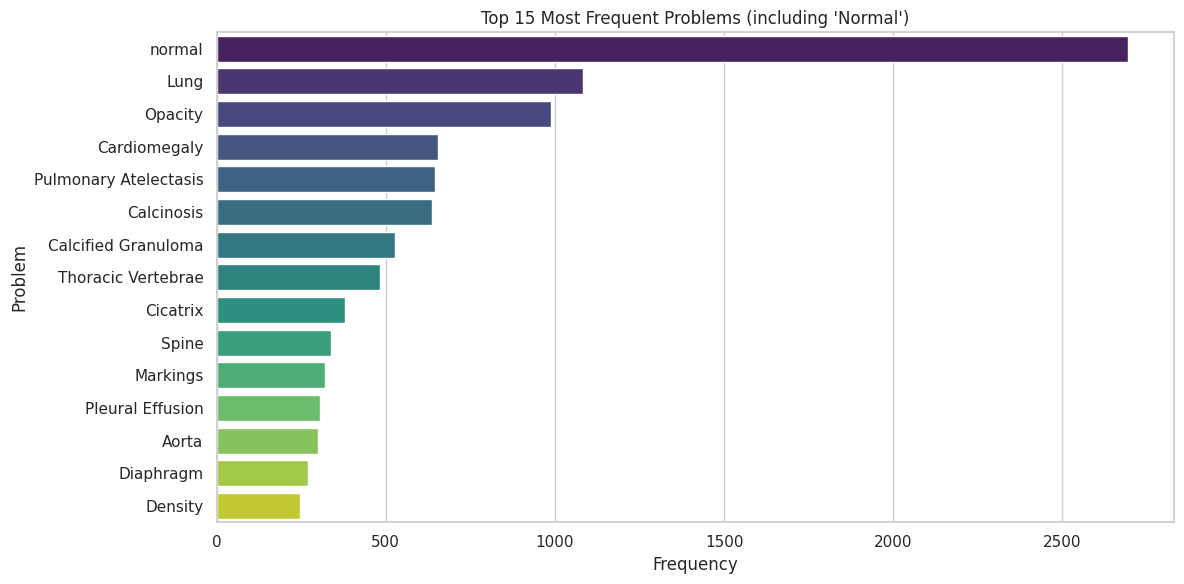

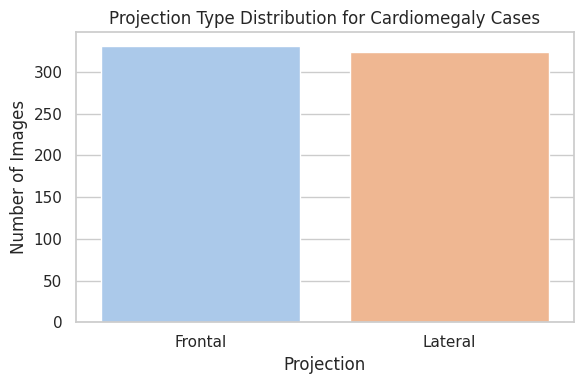

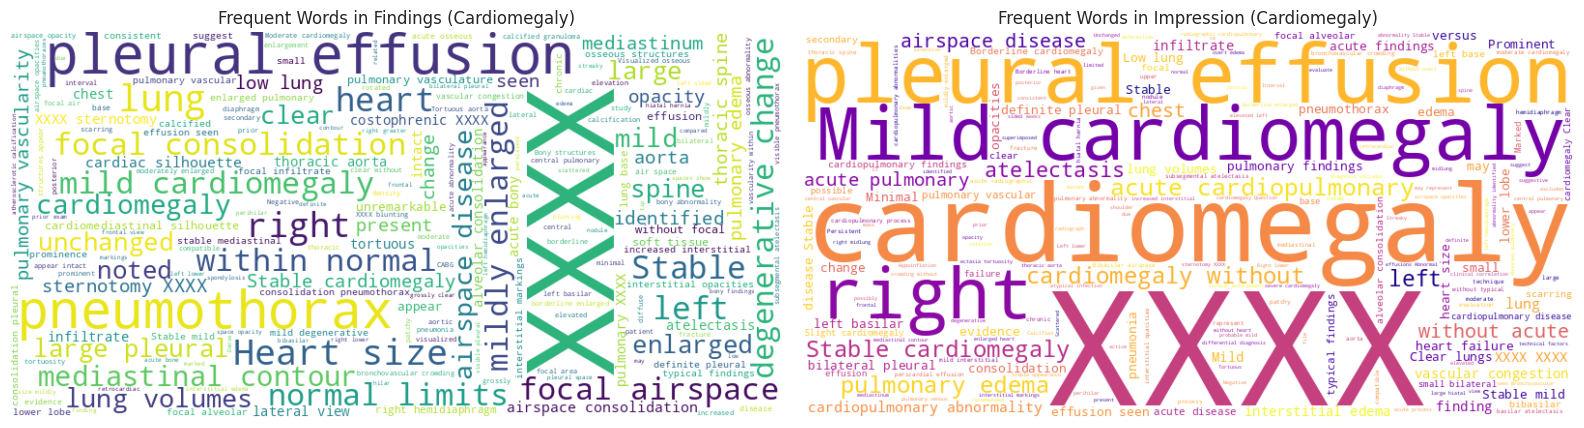

In [51]:
from collections import Counter
from wordcloud import WordCloud

# ========== Analyze the distribution of diseases ==========
# Split the "Problems" column by ';' and flatten the list
problems_split = meta['Problems'].dropna().str.split(';')
problems_flat = [item.strip() for sublist in problems_split for item in sublist]

# Count frequency of each problem (including 'Normal')
problem_counts = Counter(problems_flat)
top_problems = problem_counts.most_common(15)

# Create a DataFrame for plotting
problem_df = pd.DataFrame(top_problems, columns=['Problem', 'Count'])

# Plot top 15 most frequent problems
plt.figure(figsize=(12, 6))
sns.barplot(data=problem_df, x='Count', y='Problem', palette="viridis")
plt.title("Top 15 Most Frequent Problems (including 'Normal')")
plt.xlabel("Frequency")
plt.ylabel("Problem")
plt.tight_layout()
plt.show()

# ========== Analyze projection type for Cardiomegaly ==========
# Filter rows containing 'Cardiomegaly'
cardio_df = meta[meta['Problems'].str.contains("Cardiomegaly", case=False, na=False)]

# Count projection types
projection_counts = cardio_df['projection'].value_counts()

# Create a DataFrame for plotting
projection_df = projection_counts.reset_index()
projection_df.columns = ['Projection', 'Count']

# Plot projection distribution
plt.figure(figsize=(6, 4))
sns.barplot(data=projection_df, x='Projection', y='Count', palette="pastel")
plt.title("Projection Type Distribution for Cardiomegaly Cases")
plt.xlabel("Projection")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# ========== Generate WordClouds for Findings and Impression ==========
# Combine text for Cardiomegaly cases
text_findings = " ".join(cardio_df['findings'].dropna().astype(str))
text_impression = " ".join(cardio_df['impression'].dropna().astype(str))

# Generate word clouds
wordcloud_findings = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_findings)
wordcloud_impression = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(text_impression)

# Plot word clouds side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_findings, interpolation='bilinear')
plt.axis('off')
plt.title("Frequent Words in Findings (Cardiomegaly)")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_impression, interpolation='bilinear')
plt.axis('off')
plt.title("Frequent Words in Impression (Cardiomegaly)")

plt.tight_layout()
plt.show()


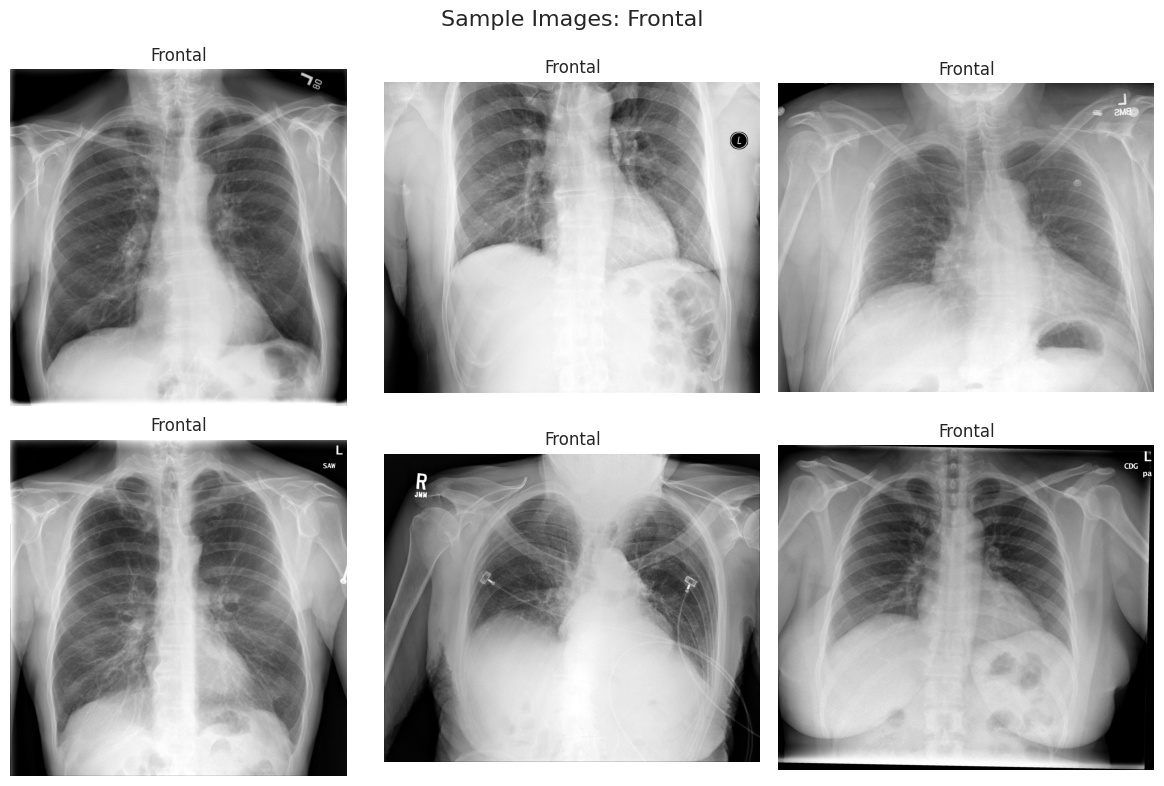

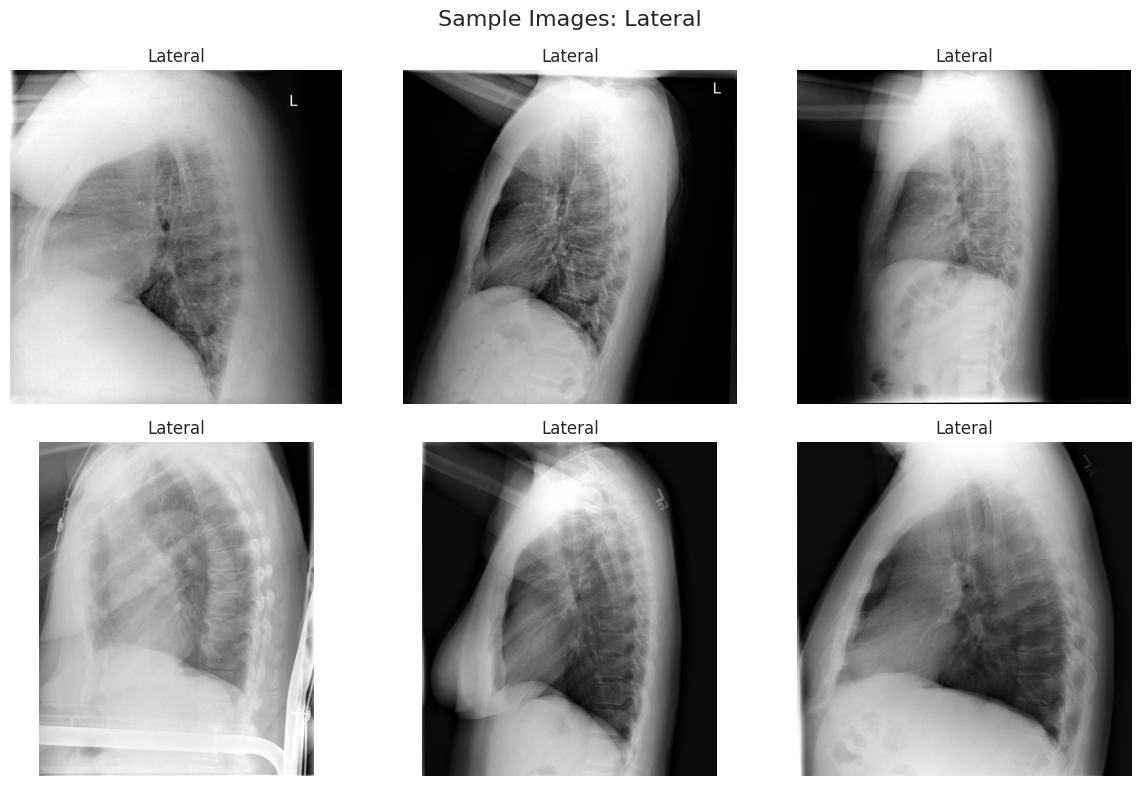

In [5]:
#  Sample Image Grid per Projection

def plot_samples_by_projection(proj, n=6, seed=42):
    subset = meta[meta.projection == proj]
    paths  = subset.sample(n, random_state=seed)['filepath'].tolist()
    
    cols  = 3
    rows  = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
    axes = axes.flatten()
    
    for ax, p in zip(axes, paths):
        img = Image.open(p)
        ax.imshow(img, cmap="gray")
        ax.set_title(proj)
        ax.axis("off")
    # hide any extra axes
    for ax in axes[len(paths):]:
        ax.axis("off")
        
    plt.suptitle(f"Sample Images: {proj}", fontsize=16)
    plt.tight_layout()
    plt.show()

for proj in meta['projection'].unique():
    plot_samples_by_projection(proj, n=6)

In [6]:
# Cell 6: Image Size Distribution (Height, Width)

# PIL .size returns (width, height), so reverse
dims = meta['filepath'].apply(lambda p: Image.open(p).size[::-1])
dims_df = pd.DataFrame(dims.tolist(), columns=['height','width'])

# Summary statistics
dims_df.describe()

,height,width
count,7466.000000,7466.000000
mean,2220.219395,2155.824270
std,219.141460,188.672166
min,1760.000000,1529.000000
25%,2048.000000,2048.000000
50%,2048.000000,2048.000000
75%,2496.000000,2164.000000
max,3001.000000,2891.000000


# Preprocessing

In [7]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a word to the vocabulary if it doesn't exist."""
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        """Return the index of the word. Return <unk> index if word not found."""
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        """Return the size of the vocabulary."""
        return len(self.word2idx)
import nltk
from collections import Counter

def build_vocab_from_dataframe(df, text_column, threshold):
    """Build a simple vocabulary wrapper from a DataFrame column (e.g., 'impression')."""
    counter = Counter()

    for i, text in enumerate(df[text_column]):
        if not isinstance(text, str):
            continue
        tokens = nltk.tokenize.word_tokenize(text.lower())
        counter.update(tokens)

        if (i + 1) % 1000 == 0:
            print(f"[{i+1}/{len(df)}] Tokenized the reports.")

    # Filter words by frequency threshold
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create the vocabulary and add special tokens
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add frequent words
    for word in words:
        vocab.add_word(word)

    print(f"Vocabulary size (threshold={threshold}): {len(vocab)}")
    return vocab


In [8]:
# Assuming your DataFrame is named `meta` and text column is 'impression'
vocab = build_vocab_from_dataframe(meta, text_column='impression', threshold=5)

[1000/7466] Tokenized the reports.
[2000/7466] Tokenized the reports.
[3000/7466] Tokenized the reports.
[4000/7466] Tokenized the reports.
[5000/7466] Tokenized the reports.
[6000/7466] Tokenized the reports.
[7000/7466] Tokenized the reports.
Vocabulary size (threshold=5): 839


In [9]:
# Save to file
import pickle
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# Load later
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [10]:
import argparse
import os
from PIL import Image

def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.Resampling.LANCZOS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        image_path = os.path.join(image_dir, image)
        with Image.open(image_path) as img:
            img = resize_image(img, size)
            img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 100 == 0 or i+1 == num_images:
            print("[{}/{}] Resized the images and saved into '{}'."
                  .format(i+1, num_images, output_dir))


def main(args):
    image_dir = args.image_dir
    output_dir = args.output_dir
    image_size = [args.image_size, args.image_size]
    resize_images(image_dir, output_dir, image_size)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--image_dir', type=str, default='/kaggle/input/chest-xrays-indiana-university/images/images_normalized',
                        help='Directory for input images')
    parser.add_argument('--output_dir', type=str, default='/kaggle/working/resized/',
                        help='Directory to save resized images')
    parser.add_argument('--image_size', type=int, default=256,
                        help='Target size for resized images (square)')
    parser.add_argument('-f', type=str, help='Jupyter passes this automatically; ignore it', default=None)  # <- اضافه شده

    args = parser.parse_args()
    main(args)


[100/7470] Resized the images and saved into '/kaggle/working/resized/'.
[200/7470] Resized the images and saved into '/kaggle/working/resized/'.
[300/7470] Resized the images and saved into '/kaggle/working/resized/'.
[400/7470] Resized the images and saved into '/kaggle/working/resized/'.
[500/7470] Resized the images and saved into '/kaggle/working/resized/'.
[600/7470] Resized the images and saved into '/kaggle/working/resized/'.
[700/7470] Resized the images and saved into '/kaggle/working/resized/'.
[800/7470] Resized the images and saved into '/kaggle/working/resized/'.
[900/7470] Resized the images and saved into '/kaggle/working/resized/'.
[1000/7470] Resized the images and saved into '/kaggle/working/resized/'.
[1100/7470] Resized the images and saved into '/kaggle/working/resized/'.
[1200/7470] Resized the images and saved into '/kaggle/working/resized/'.
[1300/7470] Resized the images and saved into '/kaggle/working/resized/'.
[1400/7470] Resized the images and saved into '

In [11]:
import torch
import torch.utils.data as data
from PIL import Image
import os
import nltk
from torch.utils.data import Dataset

class ChestXrayDatasetFromDF(Dataset):
    def __init__(self, dataframe, image_dir, vocab, transform=None,
                 caption_column='impression', filename_column='filepath'):
        self.df = dataframe
        self.image_dir = image_dir
        self.vocab = vocab
        self.transform = transform
        self.caption_column = caption_column
        self.filename_column = filename_column

    def __getitem__(self, index):
        row = self.df.iloc[index]
        caption_text = str(row[self.caption_column]).lower()
        img_name = img_name = os.path.basename(str(row[self.filename_column]))

        image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        tokens = nltk.tokenize.word_tokenize(caption_text)
        caption = [self.vocab('<start>')] + [self.vocab(token) for token in tokens] + [self.vocab('<end>')]
        target = torch.Tensor(caption).long()

        return image, target

    def __len__(self):
        return len(self.df)


def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths


def get_loader_from_df(df, image_dir, vocab, transform, batch_size, shuffle, num_workers):
    dataset = ChestXrayDatasetFromDF(df, image_dir, vocab, transform)
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader


# Model

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision.models import resnet152, ResNet152_Weights

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        weights = ResNet152_Weights.DEFAULT
        resnet = resnet152(weights=weights)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

# Train

In [23]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
import pandas as pd
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split

# from data_loader_df import get_loader_from_df 
# from model import EncoderCNN, DecoderRNN  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def evaluate(encoder, decoder, data_loader, criterion):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for images, captions, lengths in data_loader:
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

    avg_loss = total_loss / total_samples
    encoder.train()
    decoder.train()
    return avg_loss


def main(args):
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)

    # Transformations
    transform = transforms.Compose([
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # Load vocabulary
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Load meta DataFrame
    meta = pd.read_csv(args.meta_path)

    # Split data
    train_df, temp_df = train_test_split(meta, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    # Load data loaders
    train_loader = get_loader_from_df(train_df, args.image_dir, vocab, transform,
                                      args.batch_size, shuffle=True, num_workers=args.num_workers)
    val_loader = get_loader_from_df(val_df, args.image_dir, vocab, transform,
                                    args.batch_size, shuffle=False, num_workers=args.num_workers)
    test_loader = get_loader_from_df(test_df, args.image_dir, vocab, transform,
                                     args.batch_size, shuffle=False, num_workers=args.num_workers)

    # Models
    encoder = EncoderCNN(args.embed_size).to(device)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)

    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=args.learning_rate)

    total_step = len(train_loader)
    for epoch in range(args.num_epochs):
        for i, (images, captions, lengths) in enumerate(train_loader):
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)

            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()

            if i % args.log_step == 0:
                print(f'Epoch [{epoch+1}/{args.num_epochs}], Step [{i}/{total_step}], '
                      f'Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}')

        # Validation at the end of epoch
        val_loss = evaluate(encoder, decoder, val_loader, criterion)
        print(f'>> Epoch [{epoch+1}] Validation Loss: {val_loss:.4f}, Perplexity: {np.exp(val_loss):5.4f}')

        # Save model
        torch.save(decoder.state_dict(), os.path.join(args.model_path, f'decoder-{epoch+1}.ckpt'))
        torch.save(encoder.state_dict(), os.path.join(args.model_path, f'encoder-{epoch+1}.ckpt'))

    # Final Test
    test_loss = evaluate(encoder, decoder, test_loader, criterion)
    print(f'>> Final Test Loss: {test_loss:.4f}, Perplexity: {np.exp(test_loss):5.4f}')


# Arguments
class Args:
    model_path = 'models/'
    crop_size = 224
    vocab_path = '/kaggle/working/vocab.pkl'
    meta_path = '/kaggle/working/meta.csv'
    image_dir = '/kaggle/working/resized'
    log_step = 10
    save_step = 1000

    embed_size = 256
    hidden_size = 512
    num_layers = 1

    num_epochs = 5
    batch_size = 128
    num_workers = 2
    learning_rate = 0.001

args = Args()
main(args)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch [1/5], Step [0/47], Loss: 6.7428, Perplexity: 847.9249
Epoch [1/5], Step [10/47], Loss: 4.6567, Perplexity: 105.2838
Epoch [1/5], Step [20/47], Loss: 3.7052, Perplexity: 40.6570
Epoch [1/5], Step [30/47], Loss: 3.5520, Perplexity: 34.8831
Epoch [1/5], Step [40/47], Loss: 3.1653, Perplexity: 23.6958
>> Epoch [1] Validation Loss: 2.8916, Perplexity: 18.0225
Epoch [2/5], Step [0/47], Loss: 3.1168, Perplexity: 22.5731
Epoch [2/5], Step [10/47], Loss: 3.1587, Perplexity: 23.5403
Epoch [2/5], Step [20/47], Loss: 2.4798, Perplexity: 11.9384
Epoch [2/5], Step [30/47], Loss: 2.6379, Perplexity: 13.9840
Epoch [2/5], Step [40/47], Loss: 2.5986, Perplexity: 13.4448
>> Epoch [2] Validation Loss: 2.3060, Perplexity: 10.0341
Epoch [3/5], Step [0/47], Loss: 2.6662, Perplexity: 14.3846
Epoch [3/5], Step [10/47], Loss: 2.4680, Perplexity: 11.7986
Epoch [3/5], Step [20/47], Loss: 2.1626, Perplexity: 8.6936
Epoch [3/5], Step [30/47], Loss: 2.3380, Perplexity: 10.3609
Epoch [3/5], Step [40/47], Loss:

In [43]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
import pandas as pd
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import nltk
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')
from sklearn.model_selection import train_test_split

# from data_loader_df import get_loader_from_df 
# from model import EncoderCNN, DecoderRNN  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def calculate_bleu_scores(references, hypotheses):
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu1, bleu2, bleu3, bleu4

def evaluate_with_bleu(encoder, decoder, data_loader, criterion, vocab):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    total_samples = 0

    references = []
    hypotheses = []

    with torch.no_grad():
        for images, captions, lengths in data_loader:
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

            # Generate captions (sampled)
            sampled_ids_batch = decoder.sample(features)  # (batch_size, max_seq_length)
            sampled_ids_batch = sampled_ids_batch.cpu().numpy()

            for i in range(len(sampled_ids_batch)):
                sampled_ids = sampled_ids_batch[i]

                # Decode sampled caption
                sampled_caption = []
                for word_id in sampled_ids:
                    word = vocab.idx2word[word_id]
                    if word == '<end>':
                        break
                    if word not in ['<start>', '<pad>']:
                        sampled_caption.append(word)
                hypotheses.append(sampled_caption)

                # Decode ground truth caption
                real_caption = []
                for idx in captions[i].cpu().numpy():
                    word = vocab.idx2word[idx]
                    if word == '<end>':
                        break
                    if word not in ['<start>', '<pad>']:
                        real_caption.append(word)
                references.append([real_caption])  # Note: list of lists for corpus_bleu

    avg_loss = total_loss / total_samples
    encoder.train()
    decoder.train()

    bleu_scores = calculate_bleu_scores(references, hypotheses)
    return avg_loss, bleu_scores

def main(args):
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)

    # Transformations
    transform = transforms.Compose([
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # Load vocabulary
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Load meta DataFrame
    meta = pd.read_csv(args.meta_path)

    # Split data
    train_df, temp_df = train_test_split(meta, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    # Load data loaders
    train_loader = get_loader_from_df(train_df, args.image_dir, vocab, transform,
                                      args.batch_size, shuffle=True, num_workers=args.num_workers)
    val_loader = get_loader_from_df(val_df, args.image_dir, vocab, transform,
                                    args.batch_size, shuffle=False, num_workers=args.num_workers)
    test_loader = get_loader_from_df(test_df, args.image_dir, vocab, transform,
                                     args.batch_size, shuffle=False, num_workers=args.num_workers)

    # Models
    encoder = EncoderCNN(args.embed_size).to(device)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)

    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=args.learning_rate)

    total_step = len(train_loader)
    for epoch in range(args.num_epochs):
        for i, (images, captions, lengths) in enumerate(train_loader):
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)

            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()

            if i % args.log_step == 0:
                print(f'Epoch [{epoch+1}/{args.num_epochs}], Step [{i}/{total_step}], '
                      f'Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}')

        # Validation at the end of epoch with BLEU
        val_loss, val_bleu_scores = evaluate_with_bleu(encoder, decoder, val_loader, criterion, vocab)
        print(f'>> Epoch [{epoch+1}] Validation Loss: {val_loss:.4f}, Perplexity: {np.exp(val_loss):5.4f}')
        print(f'>> Validation BLEU-1: {val_bleu_scores[0]:.4f}, BLEU-2: {val_bleu_scores[1]:.4f}, '
              f'BLEU-3: {val_bleu_scores[2]:.4f}, BLEU-4: {val_bleu_scores[3]:.4f}')

        # Save model
        torch.save(decoder.state_dict(), os.path.join(args.model_path, f'decoder-{epoch+1}.ckpt'))
        torch.save(encoder.state_dict(), os.path.join(args.model_path, f'encoder-{epoch+1}.ckpt'))

    # Final Test with BLEU
    test_loss, test_bleu_scores = evaluate_with_bleu(encoder, decoder, test_loader, criterion, vocab)
    print(f'>> Final Test Loss: {test_loss:.4f}, Perplexity: {np.exp(test_loss):5.4f}')
    print(f'>> Final Test BLEU-1: {test_bleu_scores[0]:.4f}, BLEU-2: {test_bleu_scores[1]:.4f}, '
          f'BLEU-3: {test_bleu_scores[2]:.4f}, BLEU-4: {test_bleu_scores[3]:.4f}')


# Arguments
class Args:
    model_path = 'models/'
    crop_size = 224
    vocab_path = '/kaggle/working/vocab.pkl'
    meta_path = '/kaggle/working/meta.csv'
    image_dir = '/kaggle/working/resized'
    log_step = 10
    save_step = 1000

    embed_size = 256
    hidden_size = 512
    num_layers = 1

    num_epochs = 5
    batch_size = 128
    num_workers = 2
    learning_rate = 0.001

args = Args()
main(args)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch [1/5], Step [0/47], Loss: 6.7248, Perplexity: 832.7769
Epoch [1/5], Step [10/47], Loss: 4.6048, Perplexity: 99.9659
Epoch [1/5], Step [20/47], Loss: 4.0044, Perplexity: 54.8383
Epoch [1/5], Step [30/47], Loss: 3.3374, Perplexity: 28.1472
Epoch [1/5], Step [40/47], Loss: 3.1849, Perplexity: 24.1640
>> Epoch [1] Validation Loss: 2.8520, Perplexity: 17.3222
>> Validation BLEU-1: 0.1641, BLEU-2: 0.1230, BLEU-3: 0.1002, BLEU-4: 0.0808
Epoch [2/5], Step [0/47], Loss: 2.9266, Perplexity: 18.6636
Epoch [2/5], Step [10/47], Loss: 2.9817, Perplexity: 19.7216
Epoch [2/5], Step [20/47], Loss: 2.5975, Perplexity: 13.4299
Epoch [2/5], Step [30/47], Loss: 2.5640, Perplexity: 12.9879
Epoch [2/5], Step [40/47], Loss: 2.4966, Perplexity: 12.1408
>> Epoch [2] Validation Loss: 2.2829, Perplexity: 9.8051
>> Validation BLEU-1: 0.1636, BLEU-2: 0.1227, BLEU-3: 0.1000, BLEU-4: 0.0807
Epoch [3/5], Step [0/47], Loss: 2.6842, Perplexity: 14.6467
Epoch [3/5], Step [10/47], Loss: 2.2936, Perplexity: 9.9110
Ep

In [44]:
def sample(self, features, max_len=20):
    "Generate captions for given image features using greedy search."
    sampled_ids = []
    inputs = features.unsqueeze(1)
    
    states = None
    for _ in range(max_len):
        hiddens, states = self.lstm(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
        outputs = self.linear(hiddens.squeeze(1))     # outputs: (batch_size, vocab_size)
        _, predicted = outputs.max(1)                 # predicted: (batch_size)
        sampled_ids.append(predicted)
        inputs = self.embed(predicted)                # inputs: (batch_size, embed_size)
        inputs = inputs.unsqueeze(1)                  # inputs: (batch_size, 1, embed_size)

    sampled_ids = torch.stack(sampled_ids, 1)         # (batch_size, max_len)
    return sampled_ids


In [45]:
import matplotlib.pyplot as plt
from PIL import Image

def clean_caption(sampled_ids, vocab):
    words = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        if word == '<end>':
            break
        if word != '<start>':
            words.append(word)
    return ' '.join(words)

def caption_from_test_image(test_df, vocab, encoder, decoder, transform, image_dir):
    sample = test_df.sample(1).iloc[0]
    print(sample)
    image_path = os.path.join(image_dir, os.path.basename(sample['filepath']))

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        feature = encoder(image_tensor)
        sampled_ids = decoder.sample(feature)
        sampled_ids = sampled_ids[0].cpu().numpy()

    caption = clean_caption(sampled_ids, vocab)

    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
    plt.show()

    print(f"Generated Caption: {caption}")


uid                                                        2512
filename                              2512_IM-1034-1001.dcm.png
projection                                              Frontal
MeSH          Surgical Instruments;Pleural Effusion/left/mod...
Problems      Surgical Instruments;Pleural Effusion;Bone Dis...
image                                 Xray Chest PA and Lateral
indication    This is a XXXX-year-old female patient with hi...
comparison                          Comparison is XXXX to XXXX.
findings                                                    NaN
impression    Sternotomy XXXX are noted in XXXX. Vascular cl...
filepath      /kaggle/input/chest-xrays-indiana-university/i...
Name: 4690, dtype: object


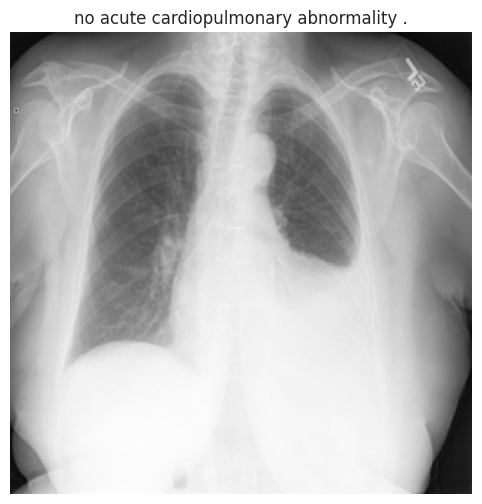

Generated Caption: no acute cardiopulmonary abnormality .


In [46]:
# Load vocab
with open(args.vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Load trained model
encoder = EncoderCNN(args.embed_size).to(device)
decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)

encoder.load_state_dict(torch.load(os.path.join(args.model_path, 'encoder-5.ckpt')))
decoder.load_state_dict(torch.load(os.path.join(args.model_path, 'decoder-5.ckpt')))

# Same transform used during training
transform = transforms.Compose([
    transforms.RandomCrop(args.crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

# Read test dataframe again
meta = pd.read_csv(args.meta_path)
_, temp_df = train_test_split(meta, test_size=0.2, random_state=42)
_, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Run captioning
caption_from_test_image(test_df, vocab, encoder, decoder, transform, args.image_dir)
